# Machine Learning | Emily Lupini #
## Asignment II ##
#### 3-Class Animals classification using K-Nearest Neighbor classifier ####

---

### 1. Gather the Dataset

I am using pathlib to access the images. Originally, I used os, but os was detecting hidden files, so I decided to provide the file names directly and concatenate those to my base directory. I then iterate through each item in the file, confirming it's a .jpg file using a regular expression.

During this iteration process each image is read in with cv2 and resized to 32x32. The labels, or in this case the given file name, are added to a labels list and the images are added to a data list.

After all the images are read, I use NumPy to convert the list into an array and the reshape the data so each image is an easier to manage vector.

The labels are transformed using LabelEncoder to assign each a number and then converted to an array with NumPy as well.

To confirm this worked I'll print the length of my labels list that is returned

*The data array, label array, and label encoder are all returned*


In [1]:
from pathlib import Path
import cv2
import numpy as np
from sklearn import preprocessing

animals = ['cats', 'dogs', 'panda']
base_path = 'KNN/animals'

def preprocess(base_path=base_path, animals=animals):
    data = []
    labels = []
    for animal in animals:
        animal_dir = Path(base_path) / animal
        for image_name in animal_dir.glob("*.jpg"):
            image = cv2.imread(str(image_name))
            image = cv2.resize(image, (32, 32), interpolation=cv2.INTER_CUBIC)
            labels.append(animal)
            data.append(image)
            
    mydata = np.array(data)
    mydata = mydata.reshape((mydata.shape[0], 3072))
    
    le = preprocessing.LabelEncoder()
    labels = le.fit_transform(labels)
    mylabels = np.array(labels)
    
    return (mydata, mylabels, le)

print('_______ Begin Reading Images _______')
data, labels, le = preprocess()
print(len(labels), 'images read.')
if len(labels) == 3000:
    print('_______ Success, Images Read _______')
else:
    print('______ Image Reading Failed! _______')

_______ Begin Reading Images _______
3000 images read.
_______ Success, Images Read _______


---
### 2. Split the Dataset

Here I renamed data and labels to X and y for ease of use and split them twice. The first time to get a 70% training set and the second time to get a 20% test set and 10% validation set from the remaining 30%.

To confirm the split was correct I check that my X_train is 70% of the original dataset


In [2]:
from sklearn.model_selection import train_test_split

X = data
y = labels

print('______ Begin Train Test Split _______')
X_train, X_tv, y_train, y_tv = train_test_split(X, y, test_size=0.30, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_tv, y_tv, test_size=0.333, random_state=42)

print(len(y_valid), 'validation values.')
if len(X_train) != (len(X)*0.7):
    print('______ Train Test Split  Failed! ______')
else:
    print('_______ Train Test Split Done _______')

______ Begin Train Test Split _______
300 validation values.
_______ Train Test Split Done _______


---
### 3. Train the Classifier
### &&
### 4. Evaluate Performance

In order to evaluate performance more efficiently, I created a dictionary that stores the best values for each distancing power: L1 representing Manhattan and L2 representing Euclidean. 

The corresponding lists contents are the accuracy, k-value, and report.

I also made lists for the validation and training accuracy scores of each distance type in order to plot a cross validation accuracy chart.

The cross validation data is graphed using the accuracy_cross_val method below which was modeled after Tovio's. I used validation instead of the test data, though, because I only used the best fit results from the validation set on my test set.

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def accuracy_cross_val(dtype, train, validate, k):
    axes = plt.gca()
    axes.set_xlim([0, len(train)])
    axes.set_ylim([min(validate)-0.2, 1.1])
    
    purple_patch = mpatches.Patch(color='purple', label='Train')
    pink_patch = mpatches.Patch(color='pink', label='Validate')
    plt.legend(handles=[purple_patch, pink_patch])
 
    title='Accuracy CrossVal {dtype}: Optimal k: {k}'.format(dtype=dtype, k=k)
    
    axes.plot(list(range(len(validate))), validate, color='pink', label='Validate Scores')
    axes.plot(list(range(len(train))), train, color='purple', label='Train Scores')
    
    plt.show()
    
    
best = {
    'l1': [0, 0, None],
    'l2': [0, 0, None]
}

l1_train_scores = []
l1_validate_scores = []
l2_train_scores = []
l2_validate_scores = []

In order to select the best k for the Manhattan distance power I generated a model for k values from 1 to 30 and selected the highest accuracy. 

A small report is printed to show the results for the best Manhattan parameters generated and then the cross validation graph is printed.

#################
### Manhattan ###
#################

Distance Type: L1 | Manhattan
	Best k =  27
	Accuracy = 50.66666666666667%
	Report:
               precision    recall  f1-score   support

        cats       0.42      0.67      0.52        91
        dogs       0.44      0.48      0.46       105
       panda       0.95      0.39      0.56       104

   micro avg       0.51      0.51      0.51       300
   macro avg       0.61      0.51      0.51       300
weighted avg       0.61      0.51      0.51       300



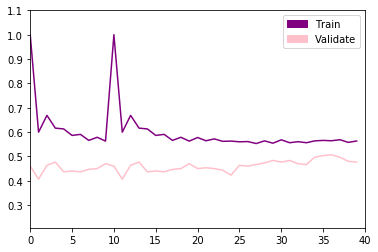

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics


print('#################')
print('### Manhattan ###')
print('#################')

for k in range(1, 31):
    
    model = KNeighborsClassifier(n_neighbors=k, p=1, n_jobs=1)
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    l1_train_scores.append(metrics.accuracy_score(y_train, y_train_pred))
    
    y_valid_pred = model.predict(X_valid)
    ac = metrics.accuracy_score(y_valid, y_valid_pred)
    l1_validate_scores.append(ac)
    
    if ac > best['l1'][0]:
        best['l1'][0] = ac
        best['l1'][1] = k
        best['l1'][2] = metrics.classification_report(y_valid, y_valid_pred, target_names=le.classes_)
        
print('\nDistance Type: L1 | Manhattan')
print('\tBest k = ', best['l1'][1])
print('\tAccuracy = {mostaccurate}%'.format(mostaccurate=(best['l1'][0]*100)))
print('\tReport:\n', best['l1'][2])

accuracy_cross_val('L1', l1_train_scores, l1_validate_scores, best['l1'][1])

I repeat the same steps above but for the Euclidean distance power.

#################
### Euclidean ###
#################

Distance Type: L2 | Euclidean
	Best k =  27
	Accuracy = 50.66666666666667%
	Report:
               precision    recall  f1-score   support

        cats       0.42      0.67      0.52        91
        dogs       0.44      0.48      0.46       105
       panda       0.95      0.39      0.56       104

   micro avg       0.51      0.51      0.51       300
   macro avg       0.61      0.51      0.51       300
weighted avg       0.61      0.51      0.51       300



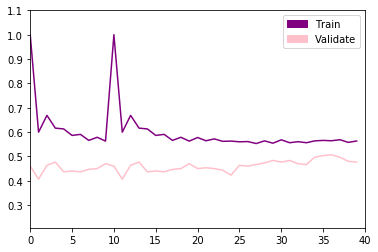

In [14]:
print('#################')
print('### Euclidean ###')
print('#################')

for k in range(1, 31):
    
    model = KNeighborsClassifier(n_neighbors=k, p=1, n_jobs=1)
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    l2_train_scores.append(metrics.accuracy_score(y_train, y_train_pred))
    
    y_valid_pred = model.predict(X_valid)
    ac = metrics.accuracy_score(y_valid, y_valid_pred)
    l2_validate_scores.append(ac)
    
    if ac > best['l2'][0]:
        best['l2'][0] = ac
        best['l2'][1] = k
        best['l2'][2] = metrics.classification_report(y_valid, y_valid_pred, target_names=le.classes_)
        
print('\nDistance Type: L2 | Euclidean')
print('\tBest k = ', best['l2'][1])
print('\tAccuracy = {mostaccurate}%'.format(mostaccurate=(best['l2'][0]*100)))
print('\tReport:\n', best['l2'][2])

accuracy_cross_val('L2', l2_train_scores, l2_validate_scores, best['l2'][1])

I then use the results from my previous two loops to decide which k and distance power I should use to run on my test set. I create a new model based on the best results and print the results.

In [15]:
print('###############')
print('### Results ###')
print('###############')

if best['l1'][0] > best['l2'][0]:
    model = KNeighborsClassifier(n_neighbors=best['l1'][1], p=1, n_jobs=-1)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    report = metrics.classification_report(y_test, y_test_pred, target_names=le.classes_)
    print('\nBest Distance Power: L1 | Manhattan')
    print('k =', best['l1'][1])
    print('Test accuracy: {accuracy}%'.format(accuracy=(metrics.accuracy_score(y_test, y_test_pred)*100)))
    print('Test Validation Report:\n', report)
else:
    model = KNeighborsClassifier(n_neighbors=best['l2'][1], p=2, n_jobs=-1)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    report = metrics.classification_report(y_test, y_test_pred, target_names=le.classes_)
    print('\nBest Distance Power: L2 | Euclidean')
    print('k =', best['l2'][1])
    print('Test accuracy: {accuracy}%'.format(accuracy=(metrics.accuracy_score(y_test, y_test_pred)*100)))
    print('Test Validation Report:\n', report)

###############
### Results ###
###############

Best Distance Power: L2 | Euclidean
k = 27
Test accuracy: 43.833333333333336%
Test Validation Report:
               precision    recall  f1-score   support

        cats       0.46      0.68      0.55       222
        dogs       0.35      0.45      0.39       186
       panda       0.88      0.15      0.26       192

   micro avg       0.44      0.44      0.44       600
   macro avg       0.56      0.43      0.40       600
weighted avg       0.56      0.44      0.41       600



Because there was so little preprocessing on my part it was hard to get an overall accuracy above 50%. Pandas, because of their pattern of distinct colors, were generally well categorized, resulting in the 80-90% accuracy range. 